In [1]:
import numpy as np
import pandas as pd
# from numba import njit
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy import stats
import datetime

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (24, 8)

In [2]:
data = pd.read_csv('Pisa201520182022_GameDataset.csv', sep = ';')

C:\Users\dwzun\AppData\Local\Temp\ipykernel_21600\1485421309.py:1: DtypeWarning: Columns (6,11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Pisa201520182022_GameDataset.csv', sep = ';')


In [75]:
data

1745082

In [3]:
df = data.loc[data['ST003D03T'].dropna().index]

In [4]:
df['birthdate'] = pd.to_datetime(df['ST003D03T'].astype(int).astype(str) + ' ' + df['ST003D02T'])

C:\Users\dwzun\AppData\Local\Temp\ipykernel_21600\1391924701.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['birthdate'] = pd.to_datetime(df['ST003D03T'].astype(int).astype(str) + ' ' + df['ST003D02T'])


In [5]:
birthmonth = df['ST003D02T']
birthyear = df['ST003D03T']

math_score = df[[f'PV{i}MATH' for i in range(1, 11)]].mean(axis = 1)
science_score = df[[f'PV{i}SCIE' for i in range(1, 11)]].mean(axis = 1)
read_score = df[[f'PV{i}READ' for i in range(1, 11)]].mean(axis = 1)



In [6]:
from time import strptime

months = birthmonth.unique()

In [7]:
int_month = []
for bm in birthmonth:
    if type(bm) == str:
        int_month.append(strptime(bm[:3],'%b').tm_mon)
    else:
        int_month.append(np.nan)

In [15]:
data_filtered = pd.DataFrame()
data_filtered['month'] = birthmonth
data_filtered['month_num'] = int_month
data_filtered['math_score'] = math_score
data_filtered['science_score'] = science_score
data_filtered['read_score'] = read_score
data_filtered['country'] = df['CNT']
data_filtered['parental_status'] = df['HISEI']
data_filtered['year'] = df.WAVE
data_filtered['year_month'] = data_filtered['year'].astype(str) + '-' + data_filtered['month']

In [25]:
import pycountry

In [30]:
def get_country_name(code):
    try:
        country = pycountry.countries.get(alpha_3=code)
        if country:
            return country.name
        else:
            return "Unknown"
    except LookupError:
        return "Unknown"

# Example usage:


In [38]:
data_filtered['country_name'] = ''
for name in data_filtered.country.unique():
    country_name = get_country_name(name)
    row_indexer = data_filtered[data_filtered.country == name].index
    data_filtered.loc[row_indexer,'country_name'] = country_name
    # print('{:^3} : {}'.format(name, country_name))

In [49]:
filtered_countries = []
for country in data_filtered.country.unique():
    if data_filtered[data_filtered.country == country].year.nunique() == 3:
        filtered_countries.append(country)

In [54]:
data_filtered = data_filtered[data_filtered.country.isin(filtered_countries)]

In [55]:
df_bp = data_filtered[data_filtered.country_name != 'Unknown']

In [72]:
data_filtered.year.unique()

array([2022, 2018, 2015], dtype=int64)

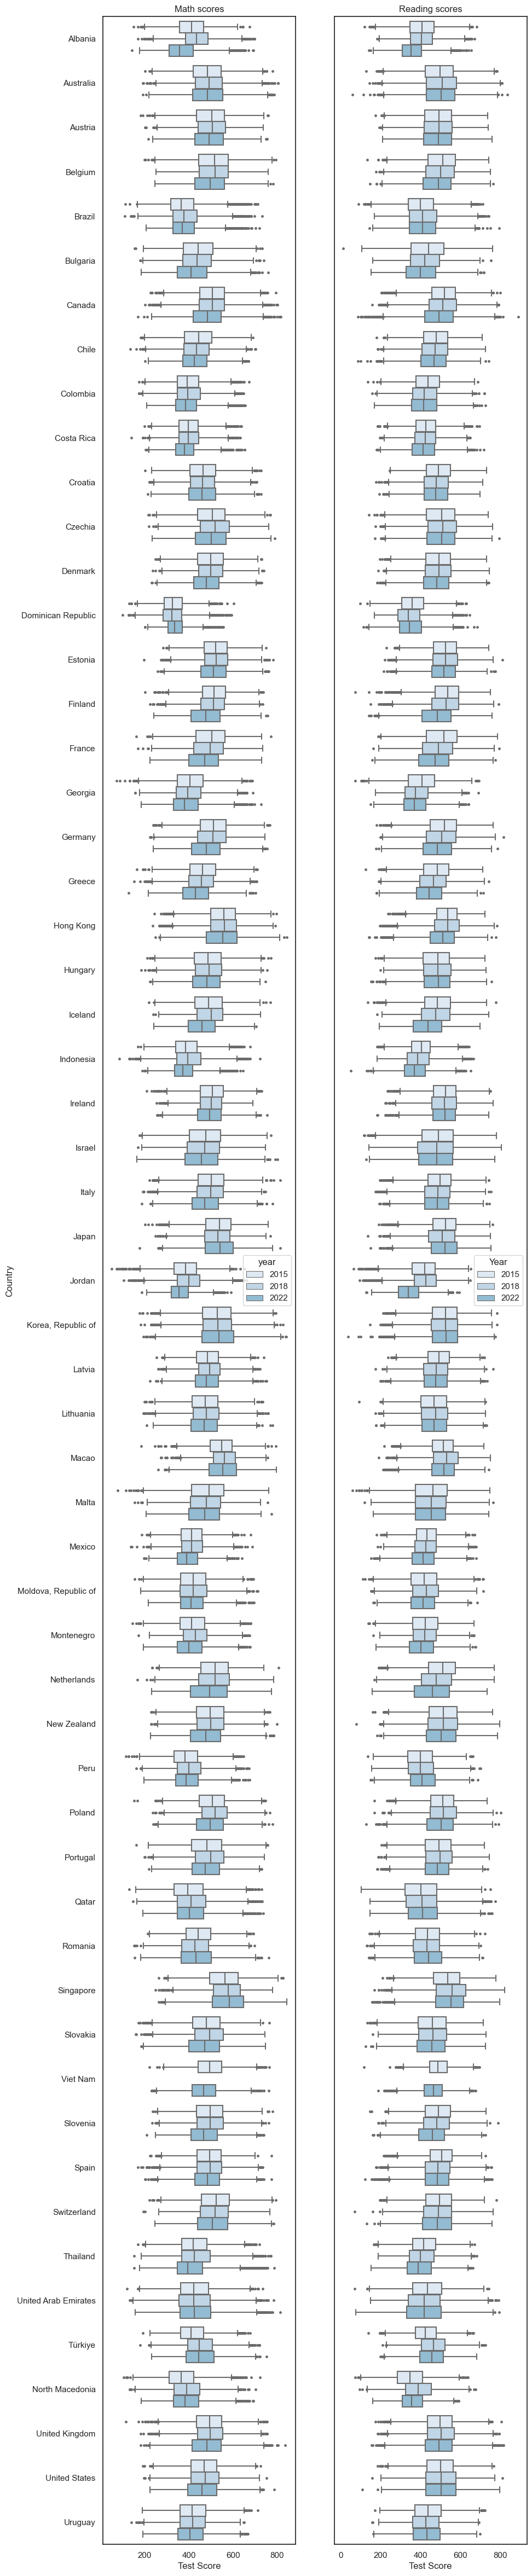

In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Create a boxplot using Seaborn with x and y axis flipped
fig, axs = plt.subplots(1, 2, figsize=(10, 60))
sns.set(style="white", palette="Blues", color_codes=True)
sns.boxplot(x='math_score', y='country_name', hue='year', data=df_bp, flierprops={"marker": "."}, ax=axs[0])
sns.boxplot(x='read_score', y='country_name', hue='year', data=df_bp, flierprops={"marker": "."}, ax=axs[1])
axs[0].set_title('Math scores')
axs[1].set_title('Reading scores')
axs[1].set(yticklabels=[])
axs[0].set_xlabel('Test Score')
axs[0].set_ylabel('Country')
axs[1].set_xlabel('Test Score')
axs[1].set_ylabel('')
plt.legend(title='Year')
plt.show()


## Cut-off point test

In [ ]:
data_filtered.head()

In [ ]:
country = "ALB"
buffer = 1
month = 6
sliced = data_filtered[data_filtered.country == country]
sliced[(sliced.month_num < month) & (sliced.month_num >= month - buffer)]

In [ ]:
def test(data, country, month, col: str = 'math_score', buffer: int = 1):
    """
    Test for significance of cut off
    PARAMS: 
        month: month of cut off, so 8 means in august, you are in group B while < august in A
    """
    sliced = data[data.country == country]
    old = sliced[(sliced.month_num < month) & (sliced.month_num >= month - buffer)][col]
    new = sliced[(sliced.month_num >= month) & (sliced.month_num < month + buffer)][col]
    



In [ ]:
interested_countries = data_filtered.country.unique()

In [ ]:
import statsmodels.formula.api as smf

In [ ]:
data_filtered[data_filtered.country == 'COL']

In [ ]:
COL = data_filtered[data_filtered.country == 'CRI']
reg_df = COL.assign(threshold=(COL["month_num"] > 2).astype(int))

model = smf.wls("math_score~month_num*threshold", reg_df).fit()

model.summary().tables[1]

In [ ]:
plt.scatter(COL.month_num, COL.math_score)

In [ ]:
COL.assign(predictions=model.fittedvalues)

In [ ]:
ax = COL.plot.scatter(x="month_num", y="math_score", color="C0")
COL.assign(predictions=model.fittedvalues).plot(x="month_num", y="predictions", ax=ax, color="C1")
plt.title("Regression Discontinuity")

In [ ]:
pd.DataFrame(interested_countries).to_excel('test.xlsx')

In [ ]:
fig, axs = plt.subplots(len(interested_countries), 2, figsize = (18, 150))

m1, M1 = 0.8 * min(data_filtered['math_score']), 1.2 * max(data_filtered['math_score'])
m2, M2 = 0.8 * min(data_filtered['read_score']), 1.2 * max(data_filtered['read_score'])
for i, country in enumerate(interested_countries):
    data_sliced = data_filtered[(data_filtered.country == country)].groupby('month_num').mean(numeric_only = True)
    axs[i, 0].scatter(data_sliced.index, data_sliced['math_score'])
    axs[i, 1].scatter(data_sliced.index, data_sliced['read_score'])
    axs[i,0].set_title(country + ' math')
    axs[i,1].set_title(country + ' read')
    # axs[i,0].set_ylim(m1, M1)
    # axs[i,1].set_ylim(m2, M2)

plt.show() 

## Boxplot

In [ ]:
countries = interested_countries[:5]

In [ ]:
data_before = data_filtered[(data_filtered.country == country) & (data_filtered.month == 'October')]
data_after = data_filtered[(data_filtered.country == country) & (data_filtered.month == 'November')]

In [ ]:
data_before

In [ ]:
import seaborn
 
seaborn.set_theme(style='whitegrid')
fmri = seaborn.load_dataset("fmri")
 
seaborn.boxplot(x="timepoint",
                y="signal",
                data=data_before)

In [ ]:
df_bp = data_filtered[(data_filtered.month_num >= 5) & (data_filtered.month_num <= 6)]

In [ ]:
df_bp['year month'] = df_bp.

In [ ]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Create a boxplot using Seaborn with x and y axis flipped
plt.figure(figsize=(10, 30))
sns.boxplot(x='math_score', y='country', hue='month', data=df_bp, palette='Set3')
plt.title('Boxplot of Test Scores by Country and Year')
plt.xlabel('Test Score')
plt.ylabel('Country')
plt.legend(title='Year')
plt.show()


In [ ]:
fig, axs = plt.subplots(len(interested_countries), 2, figsize = (18, 150))

m1, M1 = 0.8 * min(data_filtered['math_score']), 1.2 * max(data_filtered['math_score'])
m2, M2 = 0.8 * min(data_filtered['read_score']), 1.2 * max(data_filtered['read_score'])
for i, country in enumerate(interested_countries):
    data_before = data_filtered[(data_filtered.country == country) & (data_filtered.month == 'October')]
    data_after = data_filtered[(data_filtered.country == country) & (data_filtered.month == 'November')]
    axs[i, 0].boxplot([data_before['math_score'], data_after['math_score']])
    axs[i, 1].boxplot([data_before['read_score'], data_after['read_score']])
    axs[i,0].set_title(country + ' math')
    axs[i,1].set_title(country + ' read')
    axs[i,0].set_ylim(m1, M1)
    axs[i,1].set_ylim(m2, M2)

plt.show() 

In [ ]:
plt.scatter(int_month, math_score, alpha = .05)